<a href="https://colab.research.google.com/github/SanyamOberoi/Fake-News-Detection/blob/main/Fake_News_Detection_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center> Fake News Detection using BERT</h1>

## Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2318/2318), done.
remote: Total 2650 (delta 512), reused 1350 (delta 299), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (512/512), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# installing requirements to use tensorflow/models repository
# Restart the runtime once installed (any errors to be ignored)
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 215kB 18.4MB/s 
     |████████████████████████████████| 14.5MB 247kB/s 
     |████████████████████████████████| 471kB 83.5MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 25.9MB 124kB/s 
     |████████████████████████████████| 174kB 82.1MB/s 
     |████████████████████████████████| 3.6MB 74.6MB/s 
     |████████████████████████████████| 1.1MB 59.6MB/s 
     |████████████████████████████████| 358kB 59.7MB/s 
     |████████████████████████████████| 1.1MB 46.6MB/s 
     |████████████████████████████████| 11.6MB 57.0MB/s 
     |████████████████████████████████| 36.7MB 89kB/s 
     |████████████████████████████████| 276kB 81.1MB/s 
     |████████████████████████████████| 2.2MB 73.4MB/s 
     |████████████████████████████████| 92kB 12.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 81kB 12.8MB/s

## After restarting the runtime, import libraries

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from google.colab import drive

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


## Reading in data

In [4]:
# Uploading input datasets to drive and mounting drive
drive.mount('/BERT_data', force_remount=True)

Mounted at /BERT_data


In [5]:
# Reading in input datasets
train_df_mod = pd.read_csv('/BERT_data/My Drive/BERT_data/train.csv')
test_df_mod = pd.read_csv('/BERT_data/My Drive/BERT_data/test.csv')

In [6]:
# Dropping duplicate records present in input train data
tr_df1 = train_df_mod[['title','author','text','label']].drop_duplicates()
tr_df1.shape

(20691, 4)

In [7]:
# Resetting index
tr_df1 = tr_df1.reset_index(drop=True)

In [10]:
# Creating a copy of input data for backup purposes
train_df_title = tr_df1.copy()

In [28]:
tr_df1.shape

(20691, 4)

In [11]:
# Empty title records earlier had a float datatype; converting all title records to string data type
train_df_title['normalized_cleaned_title'] = train_df_title['title'].apply(lambda x: str(x))

## Creating Train, Validation and Test splits

In [30]:
# Splitting data to create test set
X_trn, X_test, y_trn, y_test = train_test_split(train_df_title['normalized_cleaned_title'], train_df_title['label'], test_size=0.15, random_state=0, stratify=train_df_title['label'])

In [31]:
# Splitting data again to create train and validation data (needed as validation_split parameter doesn't work with tf.data.Dataset)
X_train, X_val, y_train, y_val = train_test_split(X_trn, y_trn, test_size=0.20, random_state=0, stratify=y_trn)

In [87]:
print("Train data shape: X = {}, y = {}".format(X_train.shape, y_train.shape))
print("Validation data shape: X = {}, y = {}".format(X_val.shape, y_val.shape))
print("Test data shape: X = {}, y = {}".format(X_test.shape, y_test.shape))

Train data shape: X = (14069,), y = (14069,)
Validation data shape: X = (3518,), y = (3518,)
Test data shape: X = (3104,), y = (3104,)


In [38]:
# Checking if there is a class imbalance
tr_df1['label'].value_counts()

0    10387
1    10304
Name: label, dtype: int64

## Create tf.data.Datasets for Training and Evaluation

In [39]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
  valid_data = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
  test_data = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [43]:
# Data check
for text,label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'Will Trump make America great again?', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


## Fetching Pre-trained BERT Cased Model from TensorFlow Hub

In [44]:
"""
- Input data needs to be transformed to BERT input features:
input_word_ids, input_mask, segment_ids
- BERT model tokenizer is used to tokenize the input data
"""

label_list = [0,1] # Label categories (0: reliable news, 1: unreliable news)
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32


# Fetching BERT layer and tokenizer:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2', trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

## Tokenize and Preprocess Text for BERT

In [19]:
# Function to convert row to BERT input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a = text.numpy(), text_b = None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [20]:
# Wrapper function; needed to apply to_feature() to each element of the input data
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids

  }

  return (x, label_id)

## Creating TensorFlow Input Pipeline with `tf.data`

In [45]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)) # pre-fetching input data for pre-processing to optimize runtime and resource utilization

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32) # , drop_remainder=True
  .prefetch(tf.data.experimental.AUTOTUNE))

  # test
  test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32) # , drop_remainder=True
  .prefetch(tf.data.experimental.AUTOTUNE))
  

In [46]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [47]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [48]:
# test data spec
test_data.element_spec

({'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

## Adding a Classification Head to the BERT Layer

In [49]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  # Using pooled output from BERT layer 
  drop = tf.keras.layers.Dropout(0.4)(pooled_output) # Dropout layer to avoid overfitting
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop) # Classification layer

  model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model

## Fine-Tuning BERT for Text Classification

In [50]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 108310273   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

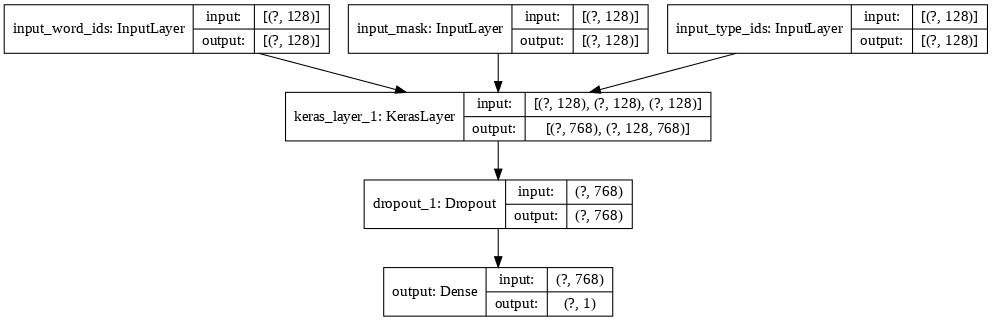

In [51]:
# Plotting the model
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [52]:
# Model training
epochs = 2
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/2
439/439 [==============================] - 221s 502ms/step - loss: 0.1756 - binary_accuracy: 0.9270 - val_loss: 0.0856 - val_binary_accuracy: 0.9628
Epoch 2/2
439/439 [==============================] - 220s 502ms/step - loss: 0.0670 - binary_accuracy: 0.9757 - val_loss: 0.0792 - val_binary_accuracy: 0.9699


## Model Performance evaluation

In [53]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

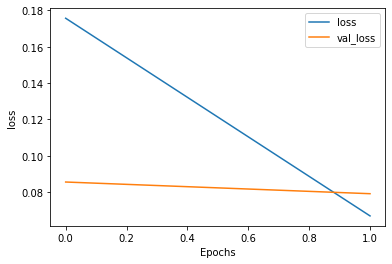

In [54]:
plot_graphs(history, 'loss')

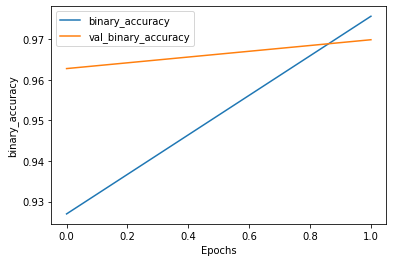

In [55]:
plot_graphs(history, 'binary_accuracy')

In [59]:
# Validation set performance
targ = []
for example in valid_data:
  for i in example[1]:
    targ.append(i.numpy())
print(len(targ))

3518


In [60]:
val_pred = model.predict(valid_data)
thres = 0.5
valid_class = [1 if pred >= thres else 0 for pred in val_pred]

In [61]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true = targ,y_pred = valid_class))
print(confusion_matrix(y_true = targ,y_pred = valid_class))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1766
           1       0.97      0.97      0.97      1752

    accuracy                           0.97      3518
   macro avg       0.97      0.97      0.97      3518
weighted avg       0.97      0.97      0.97      3518

[[1710   56]
 [  50 1702]]


In [62]:
from sklearn.metrics import accuracy_score

accuracy_score(targ, valid_class)

0.9698692438885731

In [63]:
# Test set performance
test_targ = []
for example in test_data:
  for i in example[1]:
    test_targ.append(i.numpy())
print(len(test_targ))

3104


In [64]:
test_pred = model.predict(test_data)
test_class = [1 if pred >= thres else 0 for pred in test_pred]

In [66]:
print(classification_report(y_true = test_targ,y_pred = test_class))
print(confusion_matrix(y_true = test_targ,y_pred = test_class))
print(accuracy_score(test_targ, test_class))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1558
           1       0.97      0.98      0.97      1546

    accuracy                           0.97      3104
   macro avg       0.97      0.97      0.97      3104
weighted avg       0.97      0.97      0.97      3104

[[1509   49]
 [  35 1511]]
0.9729381443298969


In [67]:
# Prediction data
test_df_mod['normalized_cleaned_title'] = test_df_mod['title'].apply(lambda x: str(x))

In [68]:
pred_data = tf.data.Dataset.from_tensor_slices((test_df_mod['normalized_cleaned_title'].values, [0]*len(test_df_mod['normalized_cleaned_title'])))
pred_data = (pred_data.map(to_feature_map).batch(1))
preds = model.predict(pred_data)
predicted_class = [1 if pred >= thres else 0 for pred in preds]

In [71]:
# Saving model
export_dir = './saved_model'
model.save(export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [72]:
# Loading saved model (for check purposes)
reloaded_model = tf.keras.models.load_model(export_dir)

In [73]:
# Checking if the model has been loaded correctly
reloaded_preds = reloaded_model.predict(pred_data)
reloaded_predicted_class = [1 if pred >= thres else 0 for pred in reloaded_preds]

assert predicted_class == reloaded_predicted_class

In [74]:
# Compressing the saved model
!zip -r /content/file.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: content/saved_model/variables/variables.index (deflated 82%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/assets/vocab.txt (deflated 49%)
  adding: content/saved_model/saved_model.pb (deflated 92%)


In [86]:
# Downloading compressed saved model
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Preparing the Submission file

In [81]:
# Submission file
id = test_df_mod['id']

submit = pd.DataFrame({'id': id, 'label': predicted_class})

In [82]:
submit.shape

(5200, 2)

In [84]:
submit.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [85]:
# Save the Submission file
submit.to_csv('./submit.csv', index=False)